<h1><font color="red">Importation

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix ,classification_report
import matplotlib.pyplot as plt
import seaborn as sns

<h1><font color="red">DataFrame

In [2]:
data_dir = os.path.join(os.getcwd(), 'images-data-64/tifinagh-images/')

try:
    labels_df = pd.read_csv(os.path.join(os.getcwd(), 'images-data-64/labels-map.csv'))
    assert 'image_path' in labels_df.columns and 'label' in labels_df.columns, "CSV must contain 'image_path' and 'label' columns"
except FileNotFoundError:
    print("labels-map.csv not found. Please check the dataset structure.")

    # Alternative : construire un DataFrame à partir des dossiers
    image_paths = []
    labels = []
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                image_paths.append(os.path.join(label_path, img_name))
                labels.append(label_dir)

    # Créer le DataFrame
    labels_df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Vérifier le DataFrame
assert not labels_df.empty, "No data loaded. Check dataset files."
print(f"Loaded {len(labels_df)} samples with {labels_df['label'].nunique()} unique classes.")

# Encoder les étiquettes
label_encoder = LabelEncoder()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
num_classes = len(label_encoder.classes_)

# Fonction pour charger et prétraiter une image RGB
def load_and_preprocess_image(image_path, target_size=(32, 32)):
    """
    Load and preprocess an image: RGB, resize, normalize
    """
    assert os.path.exists(image_path), f"Image not found: {image_path}"
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Charge l'image en couleur (BGR)
    assert img is not None, f"Failed to load image: {image_path}"
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0  # Normalisation [0, 1]
    return img.flatten()  # Aplatir en (32×32×3 = 3072) si MLP

# Charger toutes les images
X = np.array([load_and_preprocess_image(path) for path in labels_df['image_path']])
y = labels_df['label_encoded'].values

# Vérifier les dimensions
assert X.shape[0] == y.shape[0], "Mismatch between number of images and labels"
assert X.shape[1] == 32 * 32 * 3, f"Expected flattened image size of {32*32*3}, got {X.shape[1]}"
one_hot_encoder = OneHotEncoder(sparse=False)

y_one_hot = one_hot_encoder.fit_transform(y.reshape(-1, 1))

# Diviser en ensembles d'entraînement, validation et test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Convertir explicitement en NumPy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0], "Train-val-test split sizes must sum to total samples"
print(f"Train: {X_train.shape[0]} samples, Validation: {X_val.shape[0]} samples, Test: {X_test.shape[0]} samples")

# Encoder les étiquettes en one-hot pour la classification multiclasse
y_train_one_hot = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_val_one_hot = one_hot_encoder.transform(y_val.reshape(-1, 1))
y_test_one_hot = one_hot_encoder.transform(y_test.reshape(-1, 1))

# Vérifier que les tableaux one-hot sont bien des tableaux NumPy
assert isinstance(y_train_one_hot, np.ndarray)
assert isinstance(y_val_one_hot, np.ndarray)
assert isinstance(y_test_one_hot, np.ndarray)

print('X = ',X)
print('The size of the data vector X containing the images is:',X.shape)

print()

print('y = ',y)
print('The size of the label vector y is:',y.shape)

Loaded 28182 samples with 33 unique classes.
Train: 16908 samples, Validation: 5637 samples, Test: 5637 samples
X =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
The size of the data vector X containing the images is: (28182, 3072)

y =  [ 0  0  0 ... 32 32 32]
The size of the label vector y is: (28182,)


In [85]:
from PIL import Image

def load_and_preprocess_image(image_path, target_size=(32, 32)):
    """
    Load and preprocess an image using PIL: RGB, resize, normalize, flatten
    """
    assert os.path.exists(image_path), f"Image not found: {image_path}"
    try:
        img = Image.open(image_path).convert('RGB')  # Force RGB
    except Exception as e:
        raise ValueError(f"Failed to load image {image_path}: {e}")
    
    img = img.resize(target_size)
    img = np.array(img).astype(np.float32) / 255.0  # Normalize to [0, 1]
    return img.flatten()  # Shape: (32*32*3 = 3072,)


In [3]:
import numpy as np

# Activation functions
def relu(x):
    """
    ReLU activation: max(0, x)
    """
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    """
    Derivative of ReLU: 1 if x > 0, else 0
    """
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = (x > 0).astype(int)
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result


def Softmax(x):
    x_shifted = x - np.max(x, axis=1, keepdims=True)  # amélioration de la stabilité
    exp_x = np.exp(x_shifted)
    result = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    assert np.all((result >= 0) & (result <= 1)), "Softmax output must be in [0,1]"
    assert np.allclose(np.sum(result, axis=1), 1), "Softmax output must sum to 1 per sample"
    return result

Softmax(np.array([[1,0],[0,1]]))

array([[0.73105858, 0.26894142],
       [0.26894142, 0.73105858]])

<h1><font color="red">MultiClassNeuralNetwork

In [4]:
class MultiClassNeuralNetwork :
    
    def __init__(self,layer_sizes, learning_rate = 0.01, l2_lambda=0.0, optimizer="SGD"):
        """
        Initialize the neural network with given layer sizes and learning rate .
        layer_sizes : List of integers [ input_size , hidden1_size ,... , output_size ]

        """
        assert isinstance(layer_sizes,list) and len (layer_sizes)>= 2 ,"layer_sizes must be a list with at least 2 elements"
        assert all(isinstance (size,int) and size > 0 for size in layer_sizes),"All layer sizes must be positive integers"
        assert isinstance(learning_rate,(int,float)) and learning_rate > 0, " Learning rate must be a positive number "
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.l2_lambda=l2_lambda
        self.weights = []
        self.biases = []
        self.optimizer = optimizer
        
        np.random.seed(42)
        for i in range(len(self.layer_sizes)-1):
            w = np.random.randn(self.layer_sizes[i],self.layer_sizes[i+1]) * 0.01
            b = np.random.randn(1,self.layer_sizes[i+1])
            assert w.shape == (layer_sizes[i],layer_sizes[i+1]),f"Weight matrix {i+1} has incorrect shape"
            assert b.shape == (1,layer_sizes [i+1]),f"Bias vector{i+1} has incorrect shape "
            self.weights.append(w)
            self.biases.append(b)
        self.momentum = 0.9
        self.v_weights = [np.zeros_like(w) for w in self.weights]
        self.v_biases = [np.zeros_like(b) for b in self.biases]
        
    def forward(self, X):
        """
        Forward propagation: Z^{[l]} = A^{[l-1]}W^{[l]} + b^{[l]}, A^{[l]} = g(Z^{[l]})
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        self.z_values = []
        self.activations = [X]

        # Couches cachées avec ReLU
        for i in range(len(self.layer_sizes) - 2):
            z = self.activations[i] @ self.weights[i] + self.biases[i]
            assert z.shape == (X.shape[0], self.layer_sizes[i+1]), f"Z^{i+1} has incorrect shape"
            a = relu(z)
            self.z_values.append(z)
            self.activations.append(a)

        # Dernière couche avec Softmax
        z = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        assert z.shape == (X.shape[0], self.layer_sizes[-1]), "Output Z has incorrect shape"
        output = Softmax(z)
        assert output.shape == (X.shape[0], self.layer_sizes[-1]), "Output A has incorrect shape"
        self.z_values.append(z)
        self.activations.append(output)

        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        """
        Categorical Cross-Entropy: J = -1/m * sum(y_true * log(y_pred))
        """
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to loss must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        assert not np.isnan(loss), "Loss computation resulted in NaN"
        return loss
    def compute_accuracy(self, y_true, y_pred):
        """
        Compute accuracy: proportion of correct predictions
        """
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to accuracy must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

        predictions = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        accuracy = np.mean(predictions == true_labels)

        assert 0 <= accuracy <= 1, "Accuracy must be between 0 and 1"
        #print("accuracy = ",accuracy)
        return accuracy

    def backward(self,X,y,outputs):
        """
        Backpropagation: compute dW^{[l]}, db^{[l]} for each layer
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs, np.ndarray), "Inputs to backward must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape == outputs.shape, "y and outputs must have the same shape"
        
        m = X.shape[0]
        self.d_weights = [None] * len(self.weights)
        self.d_biases = [None] * len(self.biases)
        
        dZ = outputs - y
        assert dZ.shape == outputs.shape , "dZ for output layer has incorrect shape"
        self.d_weights[-1] = (self.activations [-2].T @ dZ) / m
        self.d_biases[-1] = np.sum(dZ ,axis=0 , keepdims = True) / m
        
        for l in range(len(self.weights)-2,-1,-1 ):
            dZ = (dZ @ self.weights[l+1].T) * relu_derivative(self.z_values[l])
            assert dZ.shape == (X.shape [0] , self.layer_sizes[l +1]), f"dZ ^{[ i +1]} has incorrect shape"
            self.d_weights[l] = (self.activations [l].T @ dZ) / m
            self.d_biases[l] = np.sum(dZ ,axis=0 , keepdims = True) / m   
            
        # Optimisation
        beta1 = 0.9
        beta2 = 0.999
        epsilon = 1e-8
        for i in range(len(self.weights)):

            # Ajout régularisation L2
            self.d_weights[i] += (self.l2_lambda * self.weights[i]) / m

            if self.optimizer == "momentum":
                self.v_weights[i] = self.momentum * self.v_weights[i] - self.learning_rate * self.d_weights[i]
                self.v_biases[i] = self.momentum * self.v_biases[i] - self.learning_rate * self.d_biases[i]

            elif self.optimizer == "rmsprop":
                if not hasattr(self, 's_weights'):
                    self.s_weights = [np.zeros_like(w) for w in self.weights]
                    self.s_biases = [np.zeros_like(b) for b in self.biases]
                self.s_weights[i] = beta1 * self.s_weights[i] + (1 - beta1) * self.d_weights[i]**2
                self.s_biases[i] = beta1 * self.s_biases[i] + (1 - beta1) * self.d_biases[i]**2
                self.v_weights[i] = -self.learning_rate * self.d_weights[i] / (np.sqrt(self.s_weights[i]) + epsilon)
                self.v_biases[i] = -self.learning_rate * self.d_biases[i] / (np.sqrt(self.s_biases[i]) + epsilon)

            elif self.optimizer == "adam":
                if not hasattr(self, 'm_weights'):
                    self.m_weights = [np.zeros_like(w) for w in self.weights]
                    self.vw_weights = [np.zeros_like(w) for w in self.weights]
                    self.m_biases = [np.zeros_like(b) for b in self.biases]
                    self.vw_biases = [np.zeros_like(b) for b in self.biases]
                    self.t = 0
                self.t += 1
                self.m_weights[i] = beta1 * self.m_weights[i] + (1 - beta1) * self.d_weights[i]
                self.vw_weights[i] = beta2 * self.vw_weights[i] + (1 - beta2) * (self.d_weights[i] ** 2)
                m_corr = self.m_weights[i] / (1 - beta1 ** self.t)
                v_corr = self.vw_weights[i] / (1 - beta2 ** self.t)
                self.v_weights[i] = -self.learning_rate * m_corr / (np.sqrt(v_corr) + epsilon)

                self.m_biases[i] = beta1 * self.m_biases[i] + (1 - beta1) * self.d_biases[i]
                self.vw_biases[i] = beta2 * self.vw_biases[i] + (1 - beta2) * (self.d_biases[i] ** 2)
                mb_corr = self.m_biases[i] / (1 - beta1 ** self.t)
                vb_corr = self.vw_biases[i] / (1 - beta2 ** self.t)
                self.v_biases[i] = -self.learning_rate * mb_corr / (np.sqrt(vb_corr) + epsilon)

            else:  # SGD par défaut
                self.v_weights[i] = -self.learning_rate * self.d_weights[i]
                self.v_biases[i] = -self.learning_rate * self.d_biases[i]

            # Mise à jour finale des poids
            self.weights[i] += self.v_weights[i]
            self.biases[i] += self.v_biases[i]     
            
    def train(self, X, y, X_val, y_val, X_test=None, y_test=None, epochs=100, batch_size=32):
        """
        Train the neural network using mini-batch SGD, with validation
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert isinstance(X_val, np.ndarray) and isinstance(y_val, np.ndarray), "X_val and y_val must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape[1] == self.layer_sizes[-1], f"Output dimension ({y.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert X_val.shape[1] == self.layer_sizes[0], f"Validation input dimension ({X_val.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y_val.shape[1] == self.layer_sizes[-1], f"Validation output dimension ({y_val.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        test_accuracies = []
        test_losses = []
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0]) # indice aleatoire represente une image alétoire = vecteur de meme taille que x_train
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size): # 0 3072 32
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)

            # Calculer les pertes et accuracies
            train_loss = epoch_loss / (X.shape[0] // batch_size)
            train_pred = self.forward(X)
            train_accuracy = self.compute_accuracy(y, train_pred)
            val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_pred)
            val_accuracy = self.compute_accuracy(y_val, val_pred)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            
            if X_test is not None and y_test is not None:
                test_pred = self.forward(X_test)
                test_accuracy = self.compute_accuracy(y_test, test_pred)
                test_loss = self.compute_loss(y_test, test_pred)
                test_accuracies.append(test_accuracy)
                test_losses.append(test_loss)
                #print(f"| Test Loss: {test_loss:.4f} | | Test Acc: {test_accuracy:.4f}")
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} "
                      f"Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f} ")

        return train_losses, val_losses, train_accuracies, val_accuracies #train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies

    def predict(self,X):
        """
        Predict class labels
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        outputs = self.forward(X)
        predictions = np.argmax(outputs, axis=1)
        assert predictions.shape == (X.shape[0],), "Predictions have incorrect shape"
        return predictions
                           

<h1><font color="red">without cross validation

Config learning_rate: 0.01 optimizer : SGD and regularization l2 [0.01]
Epoch   0 | Train Loss: 3.5756 | Val Loss: 3.4885 | Test Loss: 3.4874 | Train Acc: 0.0466 | Val Acc: 0.0452 | Test Acc: 0.0443
Epoch  10 | Train Loss: 3.0707 | Val Loss: 3.0275 | Test Loss: 3.0076 | Train Acc: 0.1186 | Val Acc: 0.1164 | Test Acc: 0.1176
Epoch  20 | Train Loss: 1.7732 | Val Loss: 1.8054 | Test Loss: 1.7590 | Train Acc: 0.4559 | Val Acc: 0.4408 | Test Acc: 0.4456
Epoch  30 | Train Loss: 1.1326 | Val Loss: 1.1814 | Test Loss: 1.1811 | Train Acc: 0.6509 | Val Acc: 0.6241 | Test Acc: 0.6170
Epoch  40 | Train Loss: 0.7444 | Val Loss: 0.9064 | Test Loss: 0.9159 | Train Acc: 0.7483 | Val Acc: 0.7188 | Test Acc: 0.7027
Epoch  50 | Train Loss: 0.5192 | Val Loss: 0.6495 | Test Loss: 0.6475 | Train Acc: 0.8447 | Val Acc: 0.7935 | Test Acc: 0.7919
Epoch  60 | Train Loss: 0.3857 | Val Loss: 0.5524 | Test Loss: 0.5440 | Train Acc: 0.8896 | Val Acc: 0.8290 | Test Acc: 0.8260
Epoch  70 | Train Loss: 0.2992 | Val Lo

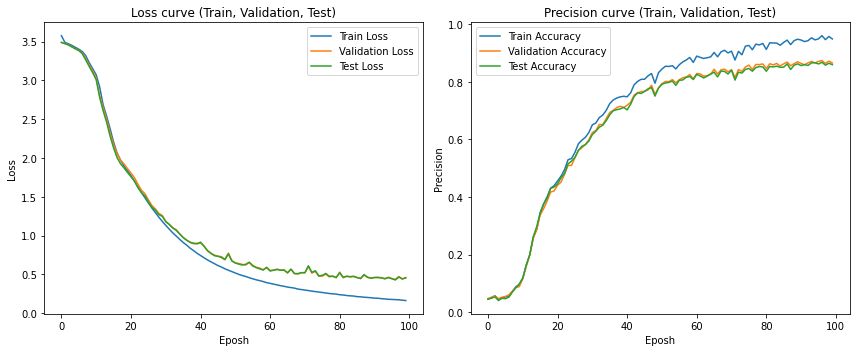

Config learning_rate: 0.01 optimizer : momentum and regularization l2 [0.01]
Epoch   0 | Train Loss: 3.4239 | Val Loss: 3.1655 | Test Loss: 3.1484 | Train Acc: 0.0924 | Val Acc: 0.0880 | Test Acc: 0.0937
Epoch  10 | Train Loss: 0.3864 | Val Loss: 0.5487 | Test Loss: 0.5498 | Train Acc: 0.8751 | Val Acc: 0.8276 | Test Acc: 0.8182
Epoch  20 | Train Loss: 0.2102 | Val Loss: 0.4939 | Test Loss: 0.4848 | Train Acc: 0.9333 | Val Acc: 0.8593 | Test Acc: 0.8552
Epoch  30 | Train Loss: 0.1412 | Val Loss: 0.4334 | Test Loss: 0.4318 | Train Acc: 0.9633 | Val Acc: 0.8767 | Test Acc: 0.8753
Epoch  40 | Train Loss: 0.1091 | Val Loss: 0.4263 | Test Loss: 0.4199 | Train Acc: 0.9721 | Val Acc: 0.8804 | Test Acc: 0.8897
Epoch  50 | Train Loss: 0.1028 | Val Loss: 0.4505 | Test Loss: 0.4590 | Train Acc: 0.9724 | Val Acc: 0.8794 | Test Acc: 0.8810
Epoch  60 | Train Loss: 0.0967 | Val Loss: 0.4028 | Test Loss: 0.4216 | Train Acc: 0.9792 | Val Acc: 0.8872 | Test Acc: 0.8936
Epoch  70 | Train Loss: 0.0511 | V

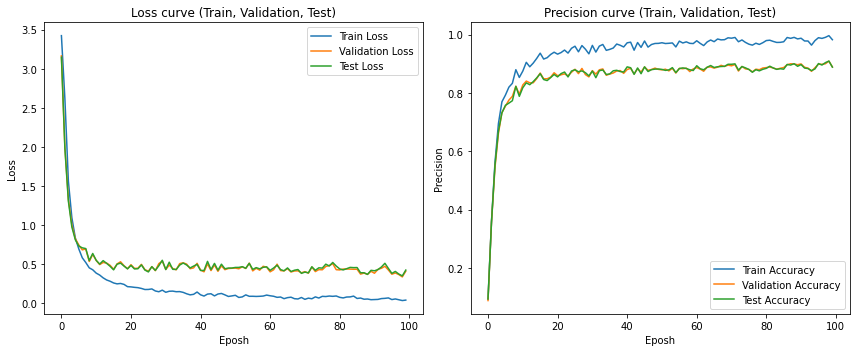

Config learning_rate: 0.01 optimizer : rmsprop and regularization l2 [0.01]
Epoch   0 | Train Loss: 1.8425 | Val Loss: 1.6932 | Test Loss: 1.6525 | Train Acc: 0.5400 | Val Acc: 0.5237 | Test Acc: 0.5283
Epoch  10 | Train Loss: 0.9231 | Val Loss: 1.2668 | Test Loss: 1.1984 | Train Acc: 0.7180 | Val Acc: 0.6832 | Test Acc: 0.6929
Epoch  20 | Train Loss: 0.8886 | Val Loss: 0.8148 | Test Loss: 0.8117 | Train Acc: 0.7828 | Val Acc: 0.7575 | Test Acc: 0.7500
Epoch  30 | Train Loss: 0.8673 | Val Loss: 0.9210 | Test Loss: 0.8932 | Train Acc: 0.7667 | Val Acc: 0.7309 | Test Acc: 0.7369
Epoch  40 | Train Loss: 0.8701 | Val Loss: 0.9429 | Test Loss: 0.9308 | Train Acc: 0.7601 | Val Acc: 0.7367 | Test Acc: 0.7323
Epoch  50 | Train Loss: 0.8516 | Val Loss: 1.0957 | Test Loss: 1.1067 | Train Acc: 0.7567 | Val Acc: 0.7353 | Test Acc: 0.7378
Epoch  60 | Train Loss: 0.8660 | Val Loss: 1.0891 | Test Loss: 1.0623 | Train Acc: 0.7259 | Val Acc: 0.6920 | Test Acc: 0.7011
Epoch  70 | Train Loss: 0.8464 | Va

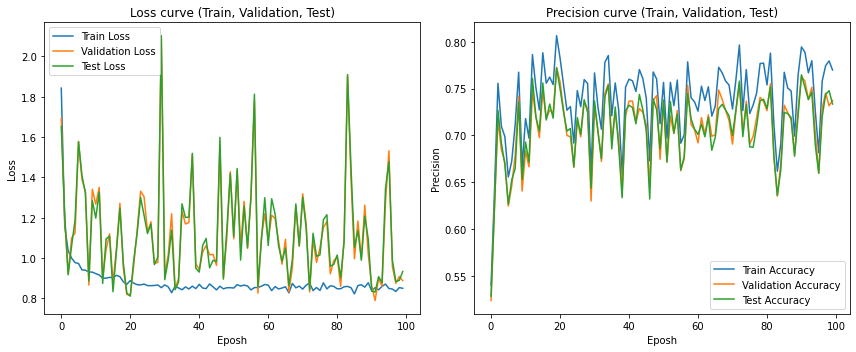

Config learning_rate: 0.01 optimizer : adam and regularization l2 [0.01]
Epoch   0 | Train Loss: 2.1516 | Val Loss: 1.6769 | Test Loss: 1.6815 | Train Acc: 0.4720 | Val Acc: 0.4623 | Test Acc: 0.4712
Epoch  10 | Train Loss: 0.9205 | Val Loss: 0.9960 | Test Loss: 0.9962 | Train Acc: 0.7154 | Val Acc: 0.6746 | Test Acc: 0.6713
Epoch  20 | Train Loss: 0.8508 | Val Loss: 0.9030 | Test Loss: 0.9065 | Train Acc: 0.7522 | Val Acc: 0.7100 | Test Acc: 0.7234
Epoch  30 | Train Loss: 0.8314 | Val Loss: 1.0584 | Test Loss: 1.0838 | Train Acc: 0.7056 | Val Acc: 0.6722 | Test Acc: 0.6706
Epoch  40 | Train Loss: 0.8355 | Val Loss: 0.9353 | Test Loss: 0.9227 | Train Acc: 0.7431 | Val Acc: 0.7089 | Test Acc: 0.6991
Epoch  50 | Train Loss: 0.8048 | Val Loss: 1.0025 | Test Loss: 1.0086 | Train Acc: 0.7211 | Val Acc: 0.6867 | Test Acc: 0.6835
Epoch  60 | Train Loss: 0.8051 | Val Loss: 0.8248 | Test Loss: 0.8317 | Train Acc: 0.7756 | Val Acc: 0.7369 | Test Acc: 0.7298
Epoch  70 | Train Loss: 0.7855 | Val L

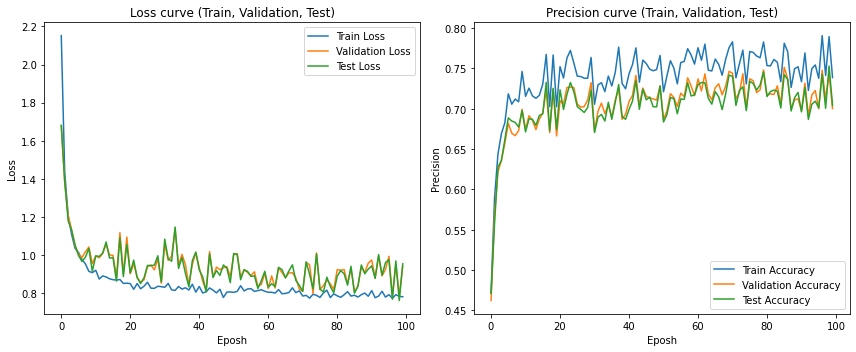

Config learning_rate: 0.001 optimizer : SGD and regularization l2 [0.01]
Epoch   0 | Train Loss: 3.9019 | Val Loss: 3.7827 | Test Loss: 3.7823 | Train Acc: 0.0303 | Val Acc: 0.0303 | Test Acc: 0.0303
Epoch  10 | Train Loss: 3.4899 | Val Loss: 3.4838 | Test Loss: 3.4826 | Train Acc: 0.0395 | Val Acc: 0.0397 | Test Acc: 0.0371
Epoch  20 | Train Loss: 3.4742 | Val Loss: 3.4688 | Test Loss: 3.4672 | Train Acc: 0.0463 | Val Acc: 0.0459 | Test Acc: 0.0442
Epoch  30 | Train Loss: 3.4540 | Val Loss: 3.4489 | Test Loss: 3.4468 | Train Acc: 0.0465 | Val Acc: 0.0495 | Test Acc: 0.0459
Epoch  40 | Train Loss: 3.4293 | Val Loss: 3.4246 | Test Loss: 3.4222 | Train Acc: 0.0460 | Val Acc: 0.0488 | Test Acc: 0.0429
Epoch  50 | Train Loss: 3.4052 | Val Loss: 3.4009 | Test Loss: 3.3980 | Train Acc: 0.0491 | Val Acc: 0.0500 | Test Acc: 0.0467
Epoch  60 | Train Loss: 3.3800 | Val Loss: 3.3765 | Test Loss: 3.3724 | Train Acc: 0.0512 | Val Acc: 0.0518 | Test Acc: 0.0490
Epoch  70 | Train Loss: 3.3443 | Val L

/Users/macbookpro/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookpro/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookpro/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


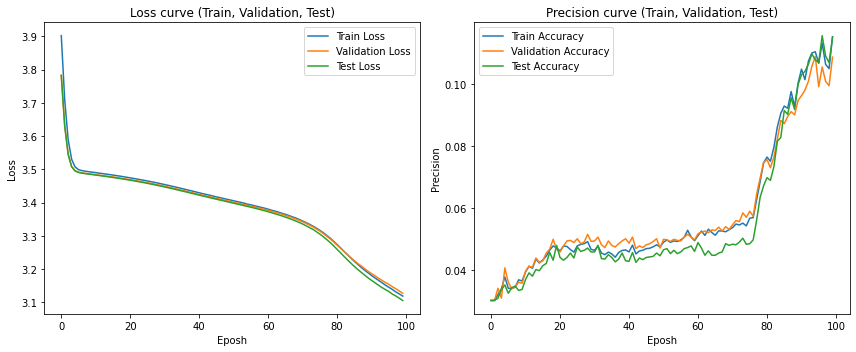

Config learning_rate: 0.001 optimizer : momentum and regularization l2 [0.01]
Epoch   0 | Train Loss: 3.5851 | Val Loss: 3.4901 | Test Loss: 3.4891 | Train Acc: 0.0436 | Val Acc: 0.0422 | Test Acc: 0.0426
Epoch  10 | Train Loss: 3.0769 | Val Loss: 3.0365 | Test Loss: 3.0173 | Train Acc: 0.1199 | Val Acc: 0.1162 | Test Acc: 0.1146
Epoch  20 | Train Loss: 1.7929 | Val Loss: 1.8181 | Test Loss: 1.7654 | Train Acc: 0.4539 | Val Acc: 0.4385 | Test Acc: 0.4454
Epoch  30 | Train Loss: 1.1559 | Val Loss: 1.2024 | Test Loss: 1.1980 | Train Acc: 0.6447 | Val Acc: 0.6161 | Test Acc: 0.6115
Epoch  40 | Train Loss: 0.7604 | Val Loss: 0.8393 | Test Loss: 0.8505 | Train Acc: 0.7701 | Val Acc: 0.7359 | Test Acc: 0.7288
Epoch  50 | Train Loss: 0.5267 | Val Loss: 0.6500 | Test Loss: 0.6565 | Train Acc: 0.8466 | Val Acc: 0.7962 | Test Acc: 0.7896
Epoch  60 | Train Loss: 0.3916 | Val Loss: 0.5475 | Test Loss: 0.5424 | Train Acc: 0.8931 | Val Acc: 0.8320 | Test Acc: 0.8332
Epoch  70 | Train Loss: 0.3076 | 

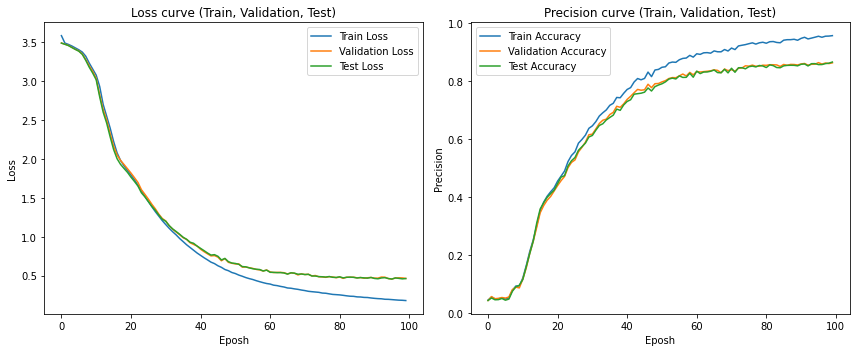

Config learning_rate: 0.001 optimizer : rmsprop and regularization l2 [0.01]
Epoch   0 | Train Loss: 2.9658 | Val Loss: 2.4157 | Test Loss: 2.3775 | Train Acc: 0.2609 | Val Acc: 0.2549 | Test Acc: 0.2585
Epoch  10 | Train Loss: 0.6747 | Val Loss: 0.7497 | Test Loss: 0.7409 | Train Acc: 0.8066 | Val Acc: 0.7573 | Test Acc: 0.7586
Epoch  20 | Train Loss: 0.3667 | Val Loss: 0.5407 | Test Loss: 0.5453 | Train Acc: 0.8949 | Val Acc: 0.8308 | Test Acc: 0.8309
Epoch  30 | Train Loss: 0.2668 | Val Loss: 0.4898 | Test Loss: 0.5033 | Train Acc: 0.9211 | Val Acc: 0.8471 | Test Acc: 0.8446
Epoch  40 | Train Loss: 0.2138 | Val Loss: 0.4935 | Test Loss: 0.4883 | Train Acc: 0.9429 | Val Acc: 0.8581 | Test Acc: 0.8560
Epoch  50 | Train Loss: 0.1852 | Val Loss: 0.5227 | Test Loss: 0.4956 | Train Acc: 0.9381 | Val Acc: 0.8567 | Test Acc: 0.8584
Epoch  60 | Train Loss: 0.1634 | Val Loss: 0.5707 | Test Loss: 0.5574 | Train Acc: 0.9385 | Val Acc: 0.8568 | Test Acc: 0.8480
Epoch  70 | Train Loss: 0.1512 | V

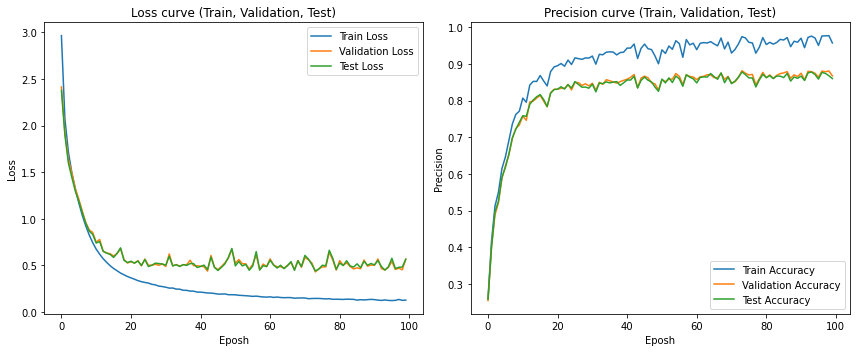

Config learning_rate: 0.001 optimizer : adam and regularization l2 [0.01]
Epoch   0 | Train Loss: 2.7064 | Val Loss: 2.0183 | Test Loss: 1.9870 | Train Acc: 0.3924 | Val Acc: 0.3731 | Test Acc: 0.3805
Epoch  10 | Train Loss: 0.5081 | Val Loss: 0.6214 | Test Loss: 0.6127 | Train Acc: 0.8465 | Val Acc: 0.7995 | Test Acc: 0.7981
Epoch  20 | Train Loss: 0.2945 | Val Loss: 0.4795 | Test Loss: 0.4773 | Train Acc: 0.9174 | Val Acc: 0.8556 | Test Acc: 0.8450
Epoch  30 | Train Loss: 0.2209 | Val Loss: 0.4841 | Test Loss: 0.5114 | Train Acc: 0.9251 | Val Acc: 0.8579 | Test Acc: 0.8446
Epoch  40 | Train Loss: 0.1756 | Val Loss: 0.4614 | Test Loss: 0.4795 | Train Acc: 0.9500 | Val Acc: 0.8664 | Test Acc: 0.8604
Epoch  50 | Train Loss: 0.1580 | Val Loss: 0.4472 | Test Loss: 0.4721 | Train Acc: 0.9566 | Val Acc: 0.8719 | Test Acc: 0.8664
Epoch  60 | Train Loss: 0.1443 | Val Loss: 0.4002 | Test Loss: 0.4335 | Train Acc: 0.9750 | Val Acc: 0.8840 | Test Acc: 0.8742
Epoch  70 | Train Loss: 0.1351 | Val 

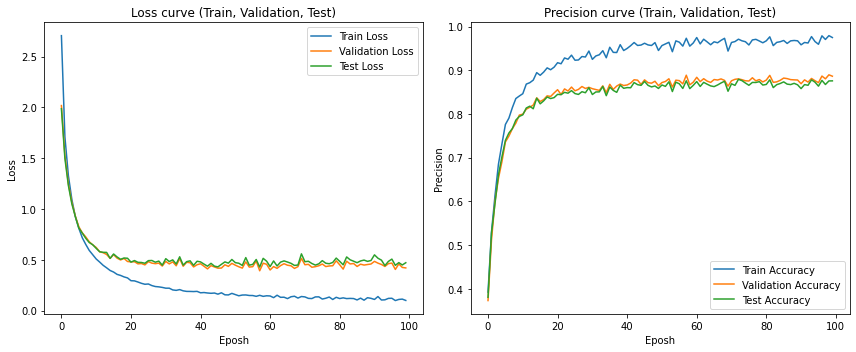

In [72]:
# Créer et entraîner le modèle
learning_rate=[0.01,0.001]
l2_lambda = [0.01]
optimizer= ['SGD',"momentum",'rmsprop','adam']
for lr in learning_rate :
    for opt in optimizer :
        print(f"Config learning_rate: {lr} optimizer : {opt} and regularization l2 {l2_lambda}")
        layer_sizes = [X_train.shape[1], 64, 32, num_classes]  # 64 et 32 neurones cachés, 33 classes
        nn = MultiClassNeuralNetwork(layer_sizes, learning_rate=lr, l2_lambda = l2_lambda[0],optimizer=opt)
        train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = nn.train(
            X_train, y_train_one_hot, X_val, y_val_one_hot, X_test, y_test_one_hot, epochs=100, batch_size=32)
        # Prédictions et évaluation
        y_pred = nn.predict(X_test)
        print("\nRapport de classification (Test set):")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

        # Matrice de confusion
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Matrice de confusion (Test set) RGB images {opt} learning rate {lr} l2_lambda {l2_lambda[0]}')
        plt.xlabel('Prédit')
        plt.ylabel('Réel')
        path = f"images/confusion_matrix_{opt}_L2_{l2_lambda[0]}_lr_{lr}.png"
        plt.savefig(path)
        plt.close()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Courbe de perte
        ax1.plot(train_losses, label='Train Loss')
        ax1.plot(val_losses, label='Validation Loss')
        ax1.plot(test_losses, label='Test Loss') 
        ax1.set_title('Loss curve (Train, Validation, Test)')
        ax1.set_xlabel('Eposh')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # Courbe de précision
        ax2.plot(train_accuracies, label='Train Accuracy')
        ax2.plot(val_accuracies, label='Validation Accuracy')
        ax2.plot(test_accuracies, label='Test Accuracy') 
        ax2.set_title(f'Precision curve (Train, Validation, Test) {opt} learning rate {lr} l2_lambda {l2_lambda[0]')
        ax2.set_xlabel('Eposh')
        ax2.set_ylabel('Precision')
        ax2.legend()

        plt.tight_layout()
        plt.show()
        path = f"images/loss_accuracy_plot_{opt}_L2_{l2_lambda[0]}_lr_{lr}.png"
        fig.savefig(path)
        plt.close()


<h1><font color="red">Regularisation 0.01

In [20]:
from sklearn.model_selection import KFold
import numpy as np

def cross_validate(model_class, X, y_one_hot, k=5, epochs=100, batch_size=32, **model_kwargs):
    """
    Effectue une validation croisée K-fold sur un modèle MultiClassNeuralNetwork.
    
    Parameters:
        model_class: la classe du modèle à instancier (ex: MultiClassNeuralNetwork)
        X (np.ndarray): données d'entrée (features)
        y_one_hot (np.ndarray): étiquettes one-hot (n_samples, n_classes)
        k (int): nombre de folds
        epochs (int): nombre d'époques par fold
        batch_size (int): taille des mini-lots
        model_kwargs: hyperparamètres pour initialiser le modèle
    
    Returns:
        Moyenne des précisions et pertes sur les folds
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    val_accuracies = []
    val_losses = []
    train_accuracies = []
    train_losses = []
    
    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}/{k}")
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y_one_hot[train_index], y_one_hot[val_index]

        model = model_class(**model_kwargs)
        train_loss, val_loss, train_accuracy, val_accuracy = model.train(
            X_train, y_train, X_val, y_val, X_test=None, y_test=None, epochs=100, batch_size=32)
        
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        
    test_pred = None #model.forward(X_test)
    test_accuracy = None #model.compute_accuracy(y_test, test_pred)
    test_loss = None #model.compute_loss(y_test, test_pred)
    
    print(f"\nMoyenne des précisions de validation : {np.mean(val_accuracies):.4f}")
    print(f"Moyenne des pertes de validation : {np.mean(val_losses):.4f}")
    print(f"\nMoyenne des précisions d'entrainement : {np.mean(train_accuracies):.4f}")
    print(f"Moyenne des pertes d'entrainement : {np.mean(train_losses):.4f}")
    #print(f"Précision de test : {test_accuracy:.4f}")
    #print(f"La perte pour les données de test : {test_loss:.4f}")
    

    return  train_losses, val_losses, test_loss ,train_accuracies, val_accuracies, test_accuracy


<h1><font color="red">Test cross_validate

In [17]:
model_args = {
                'layer_sizes': [X_train.shape[1], 64, 32, num_classes],
                'learning_rate': 0.01,
                'l2_lambda': 0.01,
                'optimizer': 'SGD'
            }
train_losses, val_losses,test_loss, train_accuracies, val_accuracies,test_accuracy = cross_validate(
                MultiClassNeuralNetwork, X, y_one_hot, k=5, epochs=50,batch_size=32, **model_args)


Fold 1/5
Epoch   0 | Train Loss: 3.5526 | Val Loss: 3.4830 Train Acc: 0.0459 | Val Acc: 0.0403 
Epoch  10 | Train Loss: 2.4659 | Val Loss: 2.3268 Train Acc: 0.2927 | Val Acc: 0.2845 
Epoch  20 | Train Loss: 1.2516 | Val Loss: 1.2514 Train Acc: 0.6134 | Val Acc: 0.6017 
Epoch  30 | Train Loss: 0.7369 | Val Loss: 0.8126 Train Acc: 0.7713 | Val Acc: 0.7406 
Epoch  40 | Train Loss: 0.4903 | Val Loss: 0.5897 Train Acc: 0.8557 | Val Acc: 0.8091 
Epoch  50 | Train Loss: 0.3612 | Val Loss: 0.5062 Train Acc: 0.8917 | Val Acc: 0.8324 
Epoch  60 | Train Loss: 0.2830 | Val Loss: 0.4736 Train Acc: 0.9100 | Val Acc: 0.8494 
Epoch  70 | Train Loss: 0.2297 | Val Loss: 0.4147 Train Acc: 0.9306 | Val Acc: 0.8636 
Epoch  80 | Train Loss: 0.1916 | Val Loss: 0.4034 Train Acc: 0.9458 | Val Acc: 0.8717 
Epoch  90 | Train Loss: 0.1624 | Val Loss: 0.3765 Train Acc: 0.9587 | Val Acc: 0.8817 

Fold 2/5
Epoch   0 | Train Loss: 3.5529 | Val Loss: 3.4812 Train Acc: 0.0445 | Val Acc: 0.0509 
Epoch  10 | Train Loss:

Configuration : layer_sizes: [3072, 64, 32, 33] learning_rate: 0.01 | optimizer : SGD | regularization l2 0.01

Fold 1/5
Epoch   0 | Train Loss: 3.5526 | Val Loss: 3.4830 Train Acc: 0.0459 | Val Acc: 0.0403 
Epoch  10 | Train Loss: 2.4659 | Val Loss: 2.3268 Train Acc: 0.2927 | Val Acc: 0.2845 
Epoch  20 | Train Loss: 1.2516 | Val Loss: 1.2514 Train Acc: 0.6134 | Val Acc: 0.6017 
Epoch  30 | Train Loss: 0.7369 | Val Loss: 0.8126 Train Acc: 0.7713 | Val Acc: 0.7406 
Epoch  40 | Train Loss: 0.4903 | Val Loss: 0.5897 Train Acc: 0.8557 | Val Acc: 0.8091 
Epoch  50 | Train Loss: 0.3612 | Val Loss: 0.5062 Train Acc: 0.8917 | Val Acc: 0.8324 
Epoch  60 | Train Loss: 0.2830 | Val Loss: 0.4736 Train Acc: 0.9100 | Val Acc: 0.8494 
Epoch  70 | Train Loss: 0.2297 | Val Loss: 0.4147 Train Acc: 0.9306 | Val Acc: 0.8636 
Epoch  80 | Train Loss: 0.1916 | Val Loss: 0.4034 Train Acc: 0.9458 | Val Acc: 0.8717 
Epoch  90 | Train Loss: 0.1624 | Val Loss: 0.3765 Train Acc: 0.9587 | Val Acc: 0.8817 

Fold 2/5

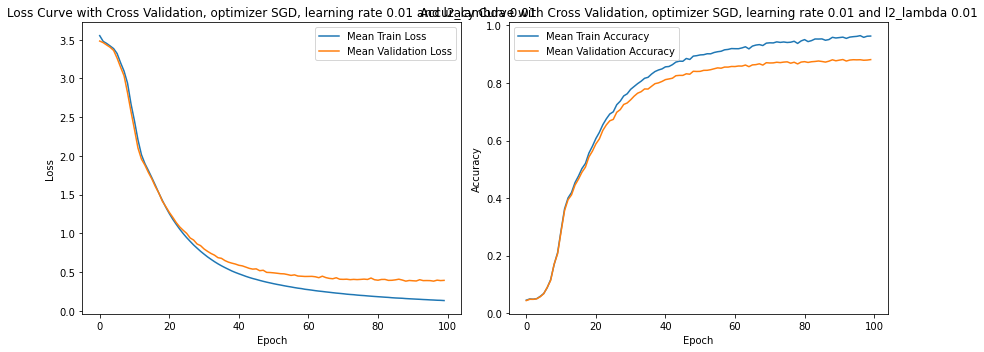

Configuration : layer_sizes: [3072, 64, 32, 33] learning_rate: 0.01 | optimizer : momentum | regularization l2 0.01

Fold 1/5
Epoch   0 | Train Loss: 3.3282 | Val Loss: 2.7893 Train Acc: 0.1505 | Val Acc: 0.1533 
Epoch  10 | Train Loss: 0.3254 | Val Loss: 0.4829 Train Acc: 0.8991 | Val Acc: 0.8542 
Epoch  20 | Train Loss: 0.2019 | Val Loss: 0.3942 Train Acc: 0.9430 | Val Acc: 0.8852 
Epoch  30 | Train Loss: 0.1611 | Val Loss: 0.4172 Train Acc: 0.9481 | Val Acc: 0.8790 
Epoch  40 | Train Loss: 0.1357 | Val Loss: 0.4040 Train Acc: 0.9535 | Val Acc: 0.8840 
Epoch  50 | Train Loss: 0.1103 | Val Loss: 0.4096 Train Acc: 0.9625 | Val Acc: 0.8918 
Epoch  60 | Train Loss: 0.1210 | Val Loss: 0.3342 Train Acc: 0.9795 | Val Acc: 0.9060 
Epoch  70 | Train Loss: 0.0943 | Val Loss: 0.3553 Train Acc: 0.9647 | Val Acc: 0.9015 
Epoch  80 | Train Loss: 0.1007 | Val Loss: 0.3305 Train Acc: 0.9783 | Val Acc: 0.9042 
Epoch  90 | Train Loss: 0.0688 | Val Loss: 0.3933 Train Acc: 0.9623 | Val Acc: 0.8866 

Fol

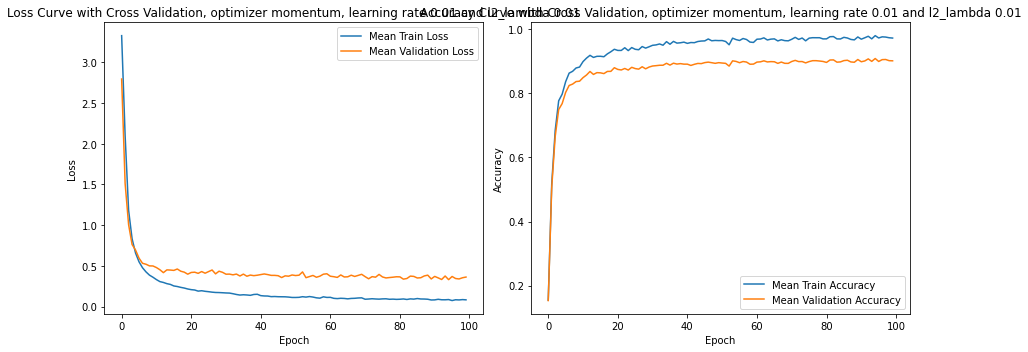

Configuration : layer_sizes: [3072, 64, 32, 33] learning_rate: 0.01 | optimizer : rmsprop | regularization l2 0.01

Fold 1/5
Epoch   0 | Train Loss: 1.6913 | Val Loss: 1.2400 Train Acc: 0.6108 | Val Acc: 0.5968 
Epoch  10 | Train Loss: 0.9370 | Val Loss: 0.9706 Train Acc: 0.7419 | Val Acc: 0.7135 
Epoch  20 | Train Loss: 0.8878 | Val Loss: 0.9940 Train Acc: 0.7425 | Val Acc: 0.7224 
Epoch  30 | Train Loss: 0.8643 | Val Loss: 0.9528 Train Acc: 0.7537 | Val Acc: 0.7332 
Epoch  40 | Train Loss: 0.8705 | Val Loss: 0.9944 Train Acc: 0.7477 | Val Acc: 0.7337 
Epoch  50 | Train Loss: 0.8673 | Val Loss: 1.3868 Train Acc: 0.7099 | Val Acc: 0.6844 
Epoch  60 | Train Loss: 0.8935 | Val Loss: 0.9444 Train Acc: 0.7527 | Val Acc: 0.7337 
Epoch  70 | Train Loss: 0.8720 | Val Loss: 0.9869 Train Acc: 0.7468 | Val Acc: 0.7245 
Epoch  80 | Train Loss: 0.8538 | Val Loss: 1.2293 Train Acc: 0.7463 | Val Acc: 0.7215 
Epoch  90 | Train Loss: 0.8605 | Val Loss: 1.3233 Train Acc: 0.7348 | Val Acc: 0.7107 

Fold

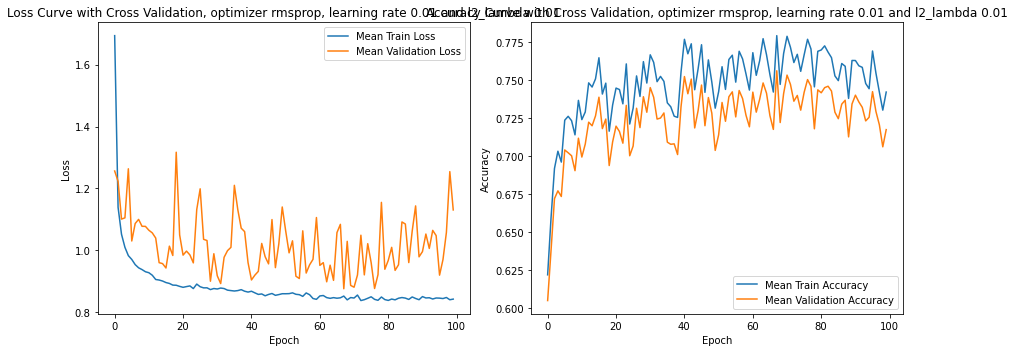

Configuration : layer_sizes: [3072, 64, 32, 33] learning_rate: 0.01 | optimizer : adam | regularization l2 0.01

Fold 1/5
Epoch   0 | Train Loss: 1.9752 | Val Loss: 1.4481 Train Acc: 0.5182 | Val Acc: 0.5159 
Epoch  10 | Train Loss: 0.9785 | Val Loss: 1.0616 Train Acc: 0.6724 | Val Acc: 0.6537 
Epoch  20 | Train Loss: 0.8876 | Val Loss: 0.8989 Train Acc: 0.7273 | Val Acc: 0.7069 
Epoch  30 | Train Loss: 0.8475 | Val Loss: 0.8469 Train Acc: 0.7516 | Val Acc: 0.7392 
Epoch  40 | Train Loss: 0.8449 | Val Loss: 0.9127 Train Acc: 0.7267 | Val Acc: 0.7060 
Epoch  50 | Train Loss: 0.8347 | Val Loss: 0.8675 Train Acc: 0.7463 | Val Acc: 0.7204 
Epoch  60 | Train Loss: 0.8245 | Val Loss: 0.8541 Train Acc: 0.7549 | Val Acc: 0.7350 
Epoch  70 | Train Loss: 0.8100 | Val Loss: 0.9036 Train Acc: 0.7344 | Val Acc: 0.7140 
Epoch  80 | Train Loss: 0.8033 | Val Loss: 0.9606 Train Acc: 0.7268 | Val Acc: 0.7066 
Epoch  90 | Train Loss: 0.8071 | Val Loss: 0.8164 Train Acc: 0.7621 | Val Acc: 0.7357 

Fold 2/

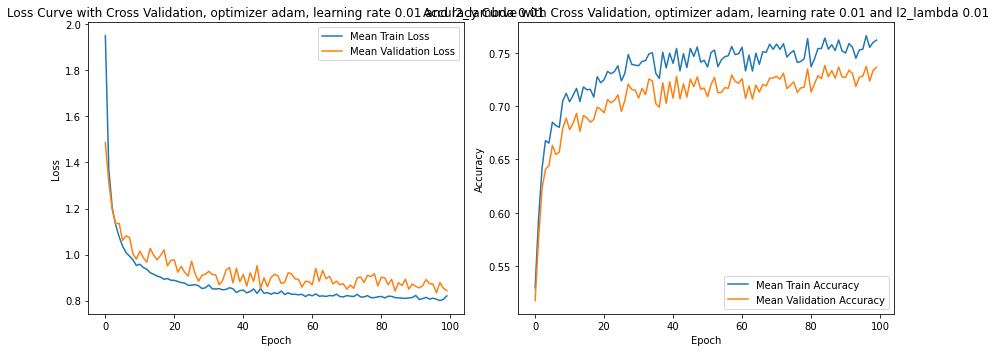

In [22]:
num_classes = y_one_hot.shape[1]
learning_rate=[0.01]#,0.001]
l2_lambda = [0.01]
optimizer= ['SGD',"momentum",'rmsprop','adam']
layer_sizes = [[X_train.shape[1], 64, 32, num_classes]]#,[X_train.shape[1], 128,64, 32, num_classes]]
for layer in layer_sizes:
    for lr in learning_rate :
        for opt in optimizer :
            model_args = {
                'layer_sizes': layer,
                'learning_rate': lr,
                'l2_lambda': l2_lambda[0],
                'optimizer': opt
            }
            print(f"Configuration : layer_sizes: {[X_train.shape[1], 64, 32, num_classes]} learning_rate: {lr} | optimizer : {opt} | regularization l2 {l2_lambda[0]}")
            train_losses, val_losses,test_loss, train_accuracies, val_accuracies,test_accuracy = cross_validate(
                MultiClassNeuralNetwork, X, y_one_hot, k=5, epochs=50,batch_size=32, **model_args)
            # Calcul des moyennes par époque (axis=0 correspond à la dimension epochs)
            mean_train_losses = np.mean(train_losses, axis=0)
            mean_val_losses = np.mean(val_losses, axis=0)
            mean_train_accs = np.mean(train_accuracies, axis=0)
            mean_val_accs = np.mean(val_accuracies, axis=0)
            print(f"test_loss= {test_loss},test_accuracy={test_accuracy}")
            
            # Tracé des courbes
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

            # Courbes de perte (loss)
            ax1.plot(mean_train_losses, label='Mean Train Loss')
            ax1.plot(mean_val_losses, label='Mean Validation Loss')
            ax1.set_title(f'Loss Curve with Cross Validation, optimizer {opt}, learning rate {lr} and l2_lambda {l2_lambda[0]}')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')
            ax1.legend()

            # Courbes de précision (accuracy)
            ax2.plot(mean_train_accs, label='Mean Train Accuracy')
            ax2.plot(mean_val_accs, label='Mean Validation Accuracy')
            ax2.set_title(f'Accuracy Curve with Cross Validation, optimizer {opt}, learning rate {lr} and l2_lambda {l2_lambda[0]}')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Accuracy')
            ax2.legend()

            plt.tight_layout()
            path = f"images/loss_accuracy_plot_{opt}_L2_{l2_lambda[0]}_lr_{lr}_cv.png"
            fig.savefig(path)
            plt.show()
